In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
import tensorflow_datasets as tfds

tfds.__version__

'4.4.0'

In [3]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir='./data',
    download=True,
    with_info=True,
    as_supervised=True,
)

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

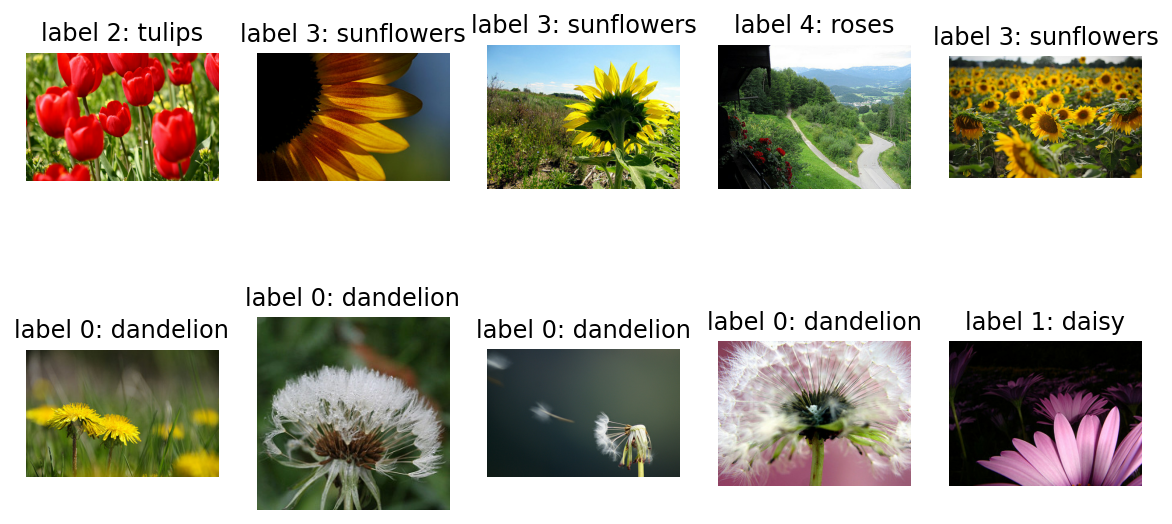

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


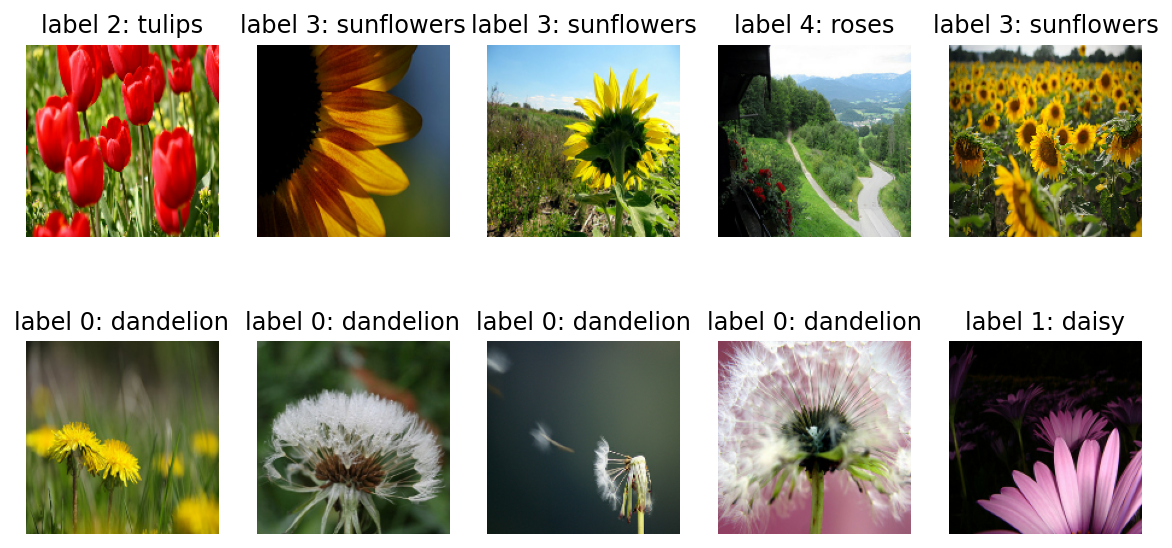

In [10]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

In [12]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [15]:
feature_batch = base_model(image_batch)
print(feature_batch)


tf.Tensor(
[[[[0.00000000e+00 0.00000000e+00 4.38215047e-01 ... 0.00000000e+00
    4.31115657e-01 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 1.11368954e+00 ... 0.00000000e+00
    6.79943621e-01 0.00000000e+00]
   [3.69774640e-01 0.00000000e+00 1.53079557e+00 ... 0.00000000e+00
    6.33961737e-01 4.39714968e-01]
   [5.16412556e-01 0.00000000e+00 1.63797498e+00 ... 0.00000000e+00
    3.04802507e-01 4.38208044e-01]
   [4.33444291e-01 0.00000000e+00 1.03799987e+00 ... 9.22201108e-03
    1.32454827e-01 4.21477705e-01]]

  [[0.00000000e+00 0.00000000e+00 7.27838993e-01 ... 0.00000000e+00
    5.70478857e-01 6.33313805e-02]
   [1.82638928e-01 0.00000000e+00 1.76623166e+00 ... 0.00000000e+00
    1.06362522e+00 3.59356582e-01]
   [9.12006080e-01 0.00000000e+00 2.13199735e+00 ... 0.00000000e+00
    8.43147814e-01 9.75976646e-01]
   [1.23419702e+00 0.00000000e+00 2.33513331e+00 ... 0.00000000e+00
    5.04863799e-01 1.04937947e+00]
   [8.83396447e-01 0.00000000e+00 1.38197124e+00 ... 0.00000

In [68]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
dense_layer = tf.keras.layers.Dense(units = 2048, activation = 'relu')
dropout_layer = tf.keras.layers.Dropout(rate=0.2)
prediction_layer = tf.keras.layers.Dense(units = 5, activation = 'softmax')
prediction_batch = prediction_layer(dense_layer(feature_batch_average))

In [69]:
base_model.trainable = False

In [70]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 10245     
Total params: 25,068,077
Trainable params: 4,206,597
Non-trainable params: 20,861,480
_________________________________________________________________


In [72]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [73]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/20 [===============>..............] - ETA: 0s - loss: 1.6452 - accuracy: 0.1705WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 20 batches). You may need to use the repeat() function when building your dataset.


20/20 [==============================] - 2s 37ms/step - loss: 1.6527 - accuracy: 0.1717
initial loss: 1.65
initial accuracy: 0.17


In [74]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy'),
]

In [75]:
EPOCHS = 20

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches,
#                     callbacks=callbacks
                   )

Epoch 1/20
92/92 [==============================] - 10s 81ms/step - loss: 0.6402 - accuracy: 0.7629 - val_loss: 0.4441 - val_accuracy: 0.8392
Epoch 2/20
92/92 [==============================] - 8s 81ms/step - loss: 0.3869 - accuracy: 0.8672 - val_loss: 0.3735 - val_accuracy: 0.8583
Epoch 3/20
92/92 [==============================] - 8s 82ms/step - loss: 0.2940 - accuracy: 0.9022 - val_loss: 0.3215 - val_accuracy: 0.8910
Epoch 4/20
92/92 [==============================] - 8s 82ms/step - loss: 0.2425 - accuracy: 0.9220 - val_loss: 0.3083 - val_accuracy: 0.8774
Epoch 5/20
92/92 [==============================] - 8s 83ms/step - loss: 0.1923 - accuracy: 0.9421 - val_loss: 0.3123 - val_accuracy: 0.8856
Epoch 6/20
92/92 [==============================] - 8s 82ms/step - loss: 0.1581 - accuracy: 0.9595 - val_loss: 0.3110 - val_accuracy: 0.8665
Epoch 7/20
92/92 [==============================] - 8s 82ms/step - loss: 0.1310 - accuracy: 0.9700 - val_loss: 0.3397 - val_accuracy: 0.8774
Epoch 8/20
9

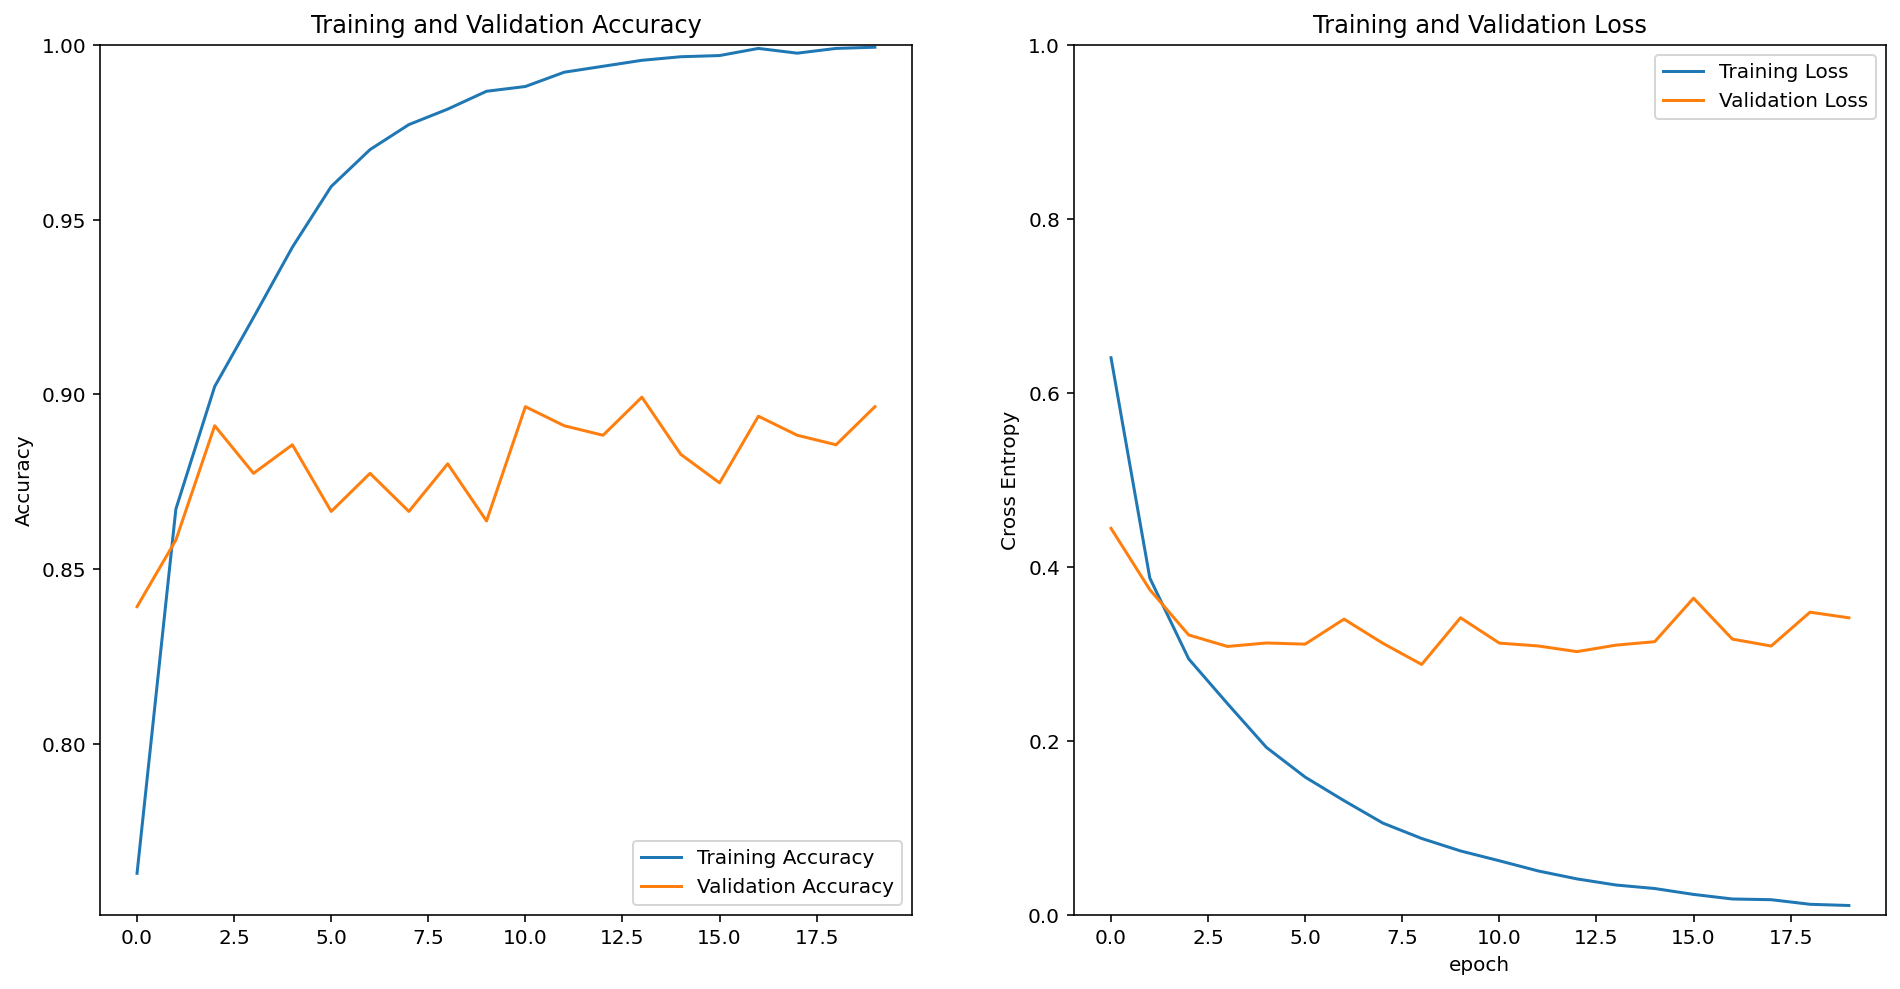

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [77]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[7.73868815e-05, 3.72121809e-04, 8.27566683e-01, 2.99204112e-05,
        1.71953931e-01],
       [1.00000000e+00, 1.28231714e-15, 3.67530349e-15, 1.14342265e-14,
        1.07429255e-16],
       [1.27232105e-01, 3.04195078e-06, 1.87014334e-03, 8.70883107e-01,
        1.16534738e-05],
       [2.89441577e-05, 3.50300630e-04, 9.89022493e-01, 6.44030195e-07,
        1.05976211e-02],
       [9.80235100e-01, 1.83811784e-02, 7.74072032e-06, 7.56714900e-04,
        6.19254948e-04],
       [9.99658346e-01, 8.28108969e-05, 5.16048385e-05, 2.03560499e-04,
        3.72182194e-06],
       [1.16995681e-04, 4.59028488e-05, 9.99833822e-01, 3.12345696e-06,
        1.16127886e-07],
       [2.75947779e-01, 6.05809510e-01, 6.71713874e-02, 4.65923250e-02,
        4.47903713e-03],
       [6.64437403e-06, 4.82711260e-10, 8.49737560e-08, 9.99992847e-01,
        3.48508678e-07],
       [1.00000000e+00, 6.32447003e-13, 7.89549056e-15, 4.90355645e-10,
        3.34063425e-13],
       [9.99972463e-01, 2.5503

In [78]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 0, 3, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       4, 0, 1, 3, 1, 4, 2, 3, 0, 4])

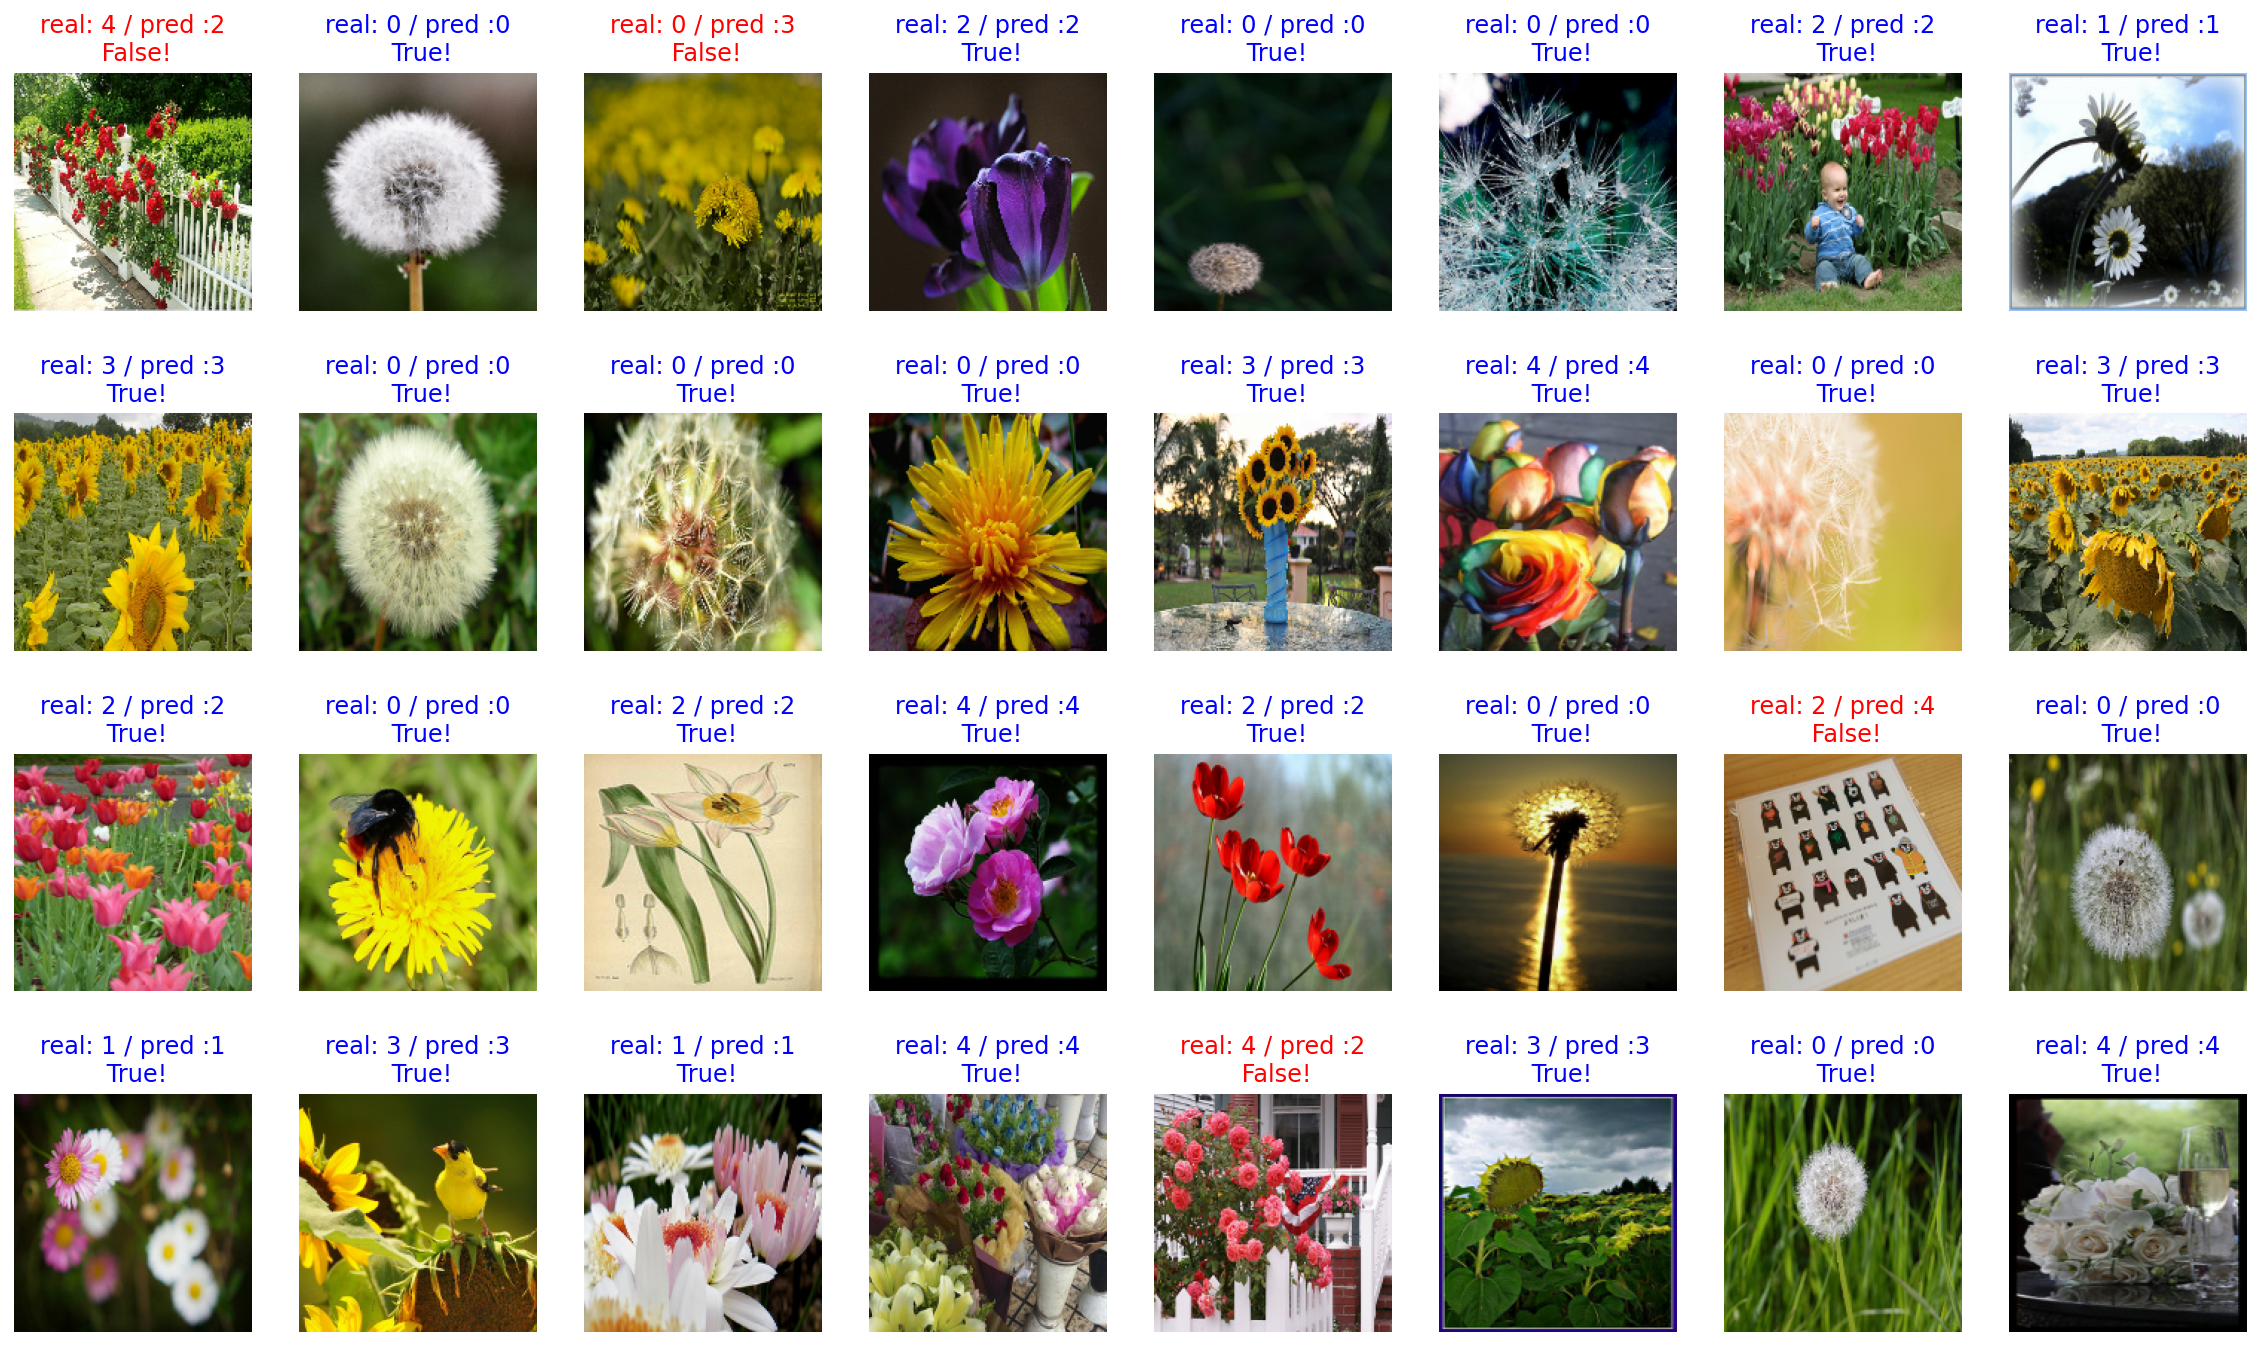

In [79]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [80]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

87.5


In [82]:
import os

checkpoint_dir =  "./"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint.weights.h5')

model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!
